In [34]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Hierarchical Cluster Guided Labeling (HCGL)

This method is based on the paper [*Efficient Label Collection for Unlabeled Image Datasets*](./Wigness_Efficient_Label_Collection_2015_CVPR_paper.pdf)

In [101]:
from pathlib import Path
import audio_features
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import pandas as pd
from scipy.cluster.hierarchy import fcluster
import random
import IPython.display as ipd
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import json

In [91]:
def read_classifications(output_file):
    """
    Read the specified file and return the count of each category
    """
    output_file = Path(output_file)
    
    classified_tracks = set()
    classifications = {'M': 0, 'D': 0, 'B': 0}
    if output_file.exists():
        classified_df = pd.read_csv(output_file)
        classified_tracks.update(classified_df['Filename'].tolist())
        # Update the classification counts with existing data
        existing_classifications = classified_df['Classification'].value_counts().to_dict()
        for key in ['M', 'D', 'B']:
            if key in existing_classifications:
                classifications[key] += existing_classifications[key]
                
    total_classifications = sum(classifications.values())

    if total_classifications > 0:
        dialog_pct = classifications["D"] / total_classifications
        music_both_pct = (classifications["M"] + classifications["B"]) / total_classifications    
    return classifications, {'Music & Both': music_both_pct, 'Dialogue': dialog_pct}

In [93]:
import random
import IPython.display as ipd
import time
def play_and_classify_m3u(m3u_file, output_file=None, num_tracks=20):
    """
    Play a specified or random number of items from an M3U file, ask user to classify as M, D, B, 
    and record the values in a file, displaying the ratio of M, D, B.
    Press 'Q' to quit at any time.
    
    Parameters:
    m3u_file (str or Path): Path to the M3U file.
    output_file (str or Path): Path to the output file where classifications are saved.
    num_tracks (int, optional): Number of tracks to play. If None, a random number of tracks will be played.
    """
    m3u_file = Path(m3u_file)

    if not output_file:
        output_file = m3u_file.parent / (m3u_file.stem + '_classification.csv')
    else:
        output_file = Path(output_file)
    
    # Read M3U file
    with m3u_file.open('r') as f:
        lines = f.readlines()
    
    # Filter lines to get only filenames (skip #EXTM3U and other comments)
    tracks = [line.strip() for line in lines if not line.startswith('#')]
    
    # Read existing classifications if the output file exists
    classified_tracks = set()
    classifications = {'M': 0, 'D': 0, 'B': 0}
    if output_file.exists():
        # classified_df = pd.read_csv(output_file)
        # classified_tracks.update(classified_df['Filename'].tolist())
        # # Update the classification counts with existing data
        # existing_classifications = classified_df['Classification'].value_counts().to_dict()
        # for key in ['M', 'D', 'B']:
        #     if key in existing_classifications:
        #         classifications[key] += existing_classifications[key]
        classifications, totals = read_classifications(output_file)
    else:
        with output_file.open('w') as out_file:
            out_file.write('Filename,Classification\n')
    
    # Filter out tracks that have already been classified
    tracks_to_play = [track for track in tracks if track not in classified_tracks]
    
    # Randomly shuffle the list of tracks to play
    random.shuffle(tracks_to_play)
    
    # Determine the number of tracks to play
    num_tracks = min(num_tracks, len(tracks_to_play))
    
    # Open output file for appending classifications
    with output_file.open('a') as out_file:
        # Play each track and ask for classification
        for i in range(num_tracks):
            track = tracks_to_play[i]
            print(f"Playing track {i + 1} of {num_tracks}: {track}")
            
            # Automatically play the audio file
            audio = ipd.Audio(track, autoplay=True)
            display_handle = ipd.display(audio, display_id=True)
            
            # Get user classification (M, D, B, or Q to quit)
            classification = None
            while classification not in ['M', 'D', 'B', 'Q']:
                classification = input("Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit): ").upper()
                if classification == 'Q':
                    print("Quitting...")
                    return
            
            # Record classification if not quitting
            if classification != 'Q':
                classifications[classification] += 1
                out_file.write(f"{track},{classification}\n")
            
            # Pause between tracks
            time.sleep(1)
            display_handle.update(ipd.HTML(''))
    
    # Calculate and display ratio of classifications
    total_classifications = sum(classifications.values())
    print("\nClassification Ratios:")
    for key, value in classifications.items():
        ratio = value / total_classifications if total_classifications > 0 else 0
        print(f"{key}: {ratio:.2f}")
    dialog_pct = classifications["D"] / total_classifications
    music_both_pct = (classifications["M"] + classifications["B"]) / total_classifications
    print(f"Music & Both: {music_both_pct * 100}; Dialogue: {dialog_pct * 100}")
    return classifications

## Load extracted features

Features such as chroma, zero-mean-crossing, RMS energy, etc. have been extracted and stored in a CSV file. 

In [11]:
feature_file = Path('241103_1441_features.csv')
training_data = Path('./TRAINING_DATA/PREPARED/outro/')

features, filenames = audio_features.read_features_from_file(feature_file)

## Perform Hiearchical Clustering

Use scipy linkages method to agglomerate the features. Various strategies are tested here. The goal is to find the best vertical cutoff that shows groupings that are easy to distinguish, have low vertical distance within the clusters and high vertical distance between other clusters. It appears that the **ward**, **median** and **average** mtehods are the most promising for distinguishing between tracks that contain *some* music versus clusters that contain only dialogue. 

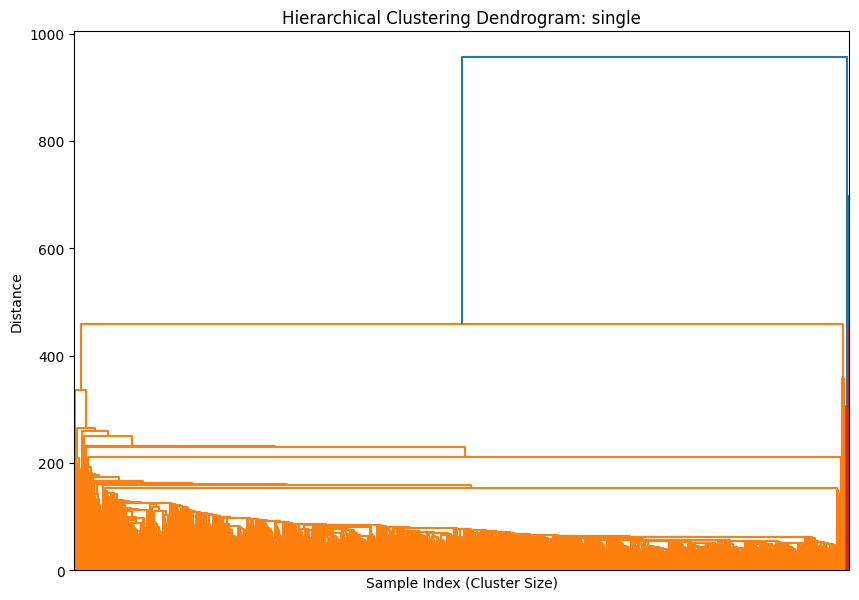

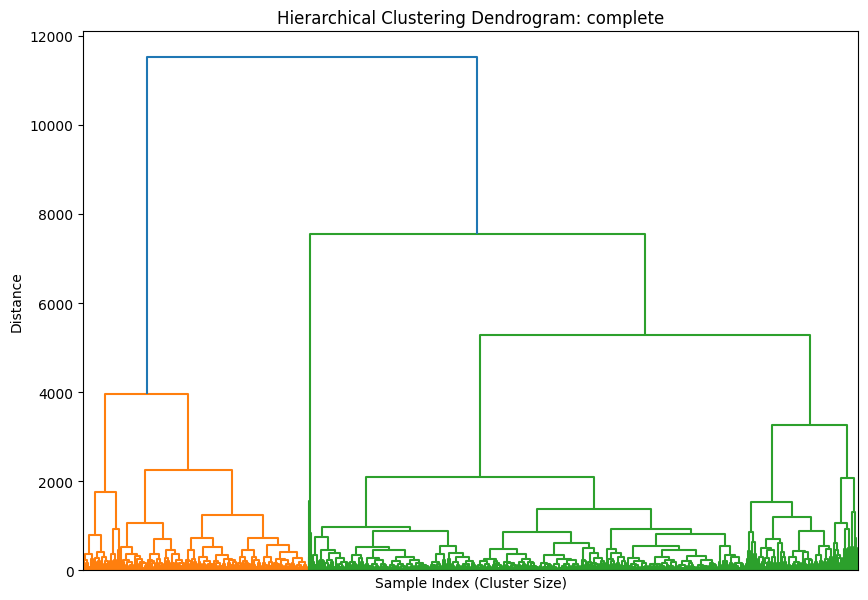

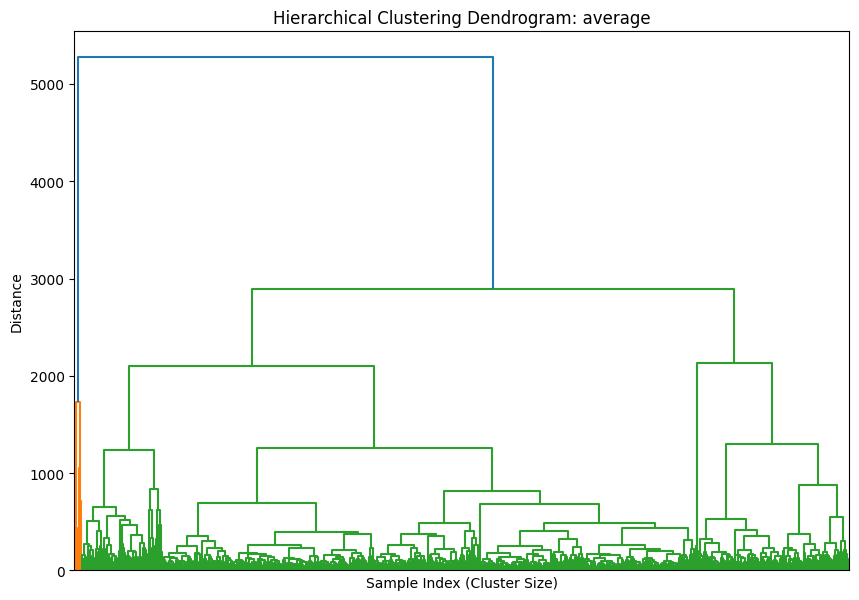

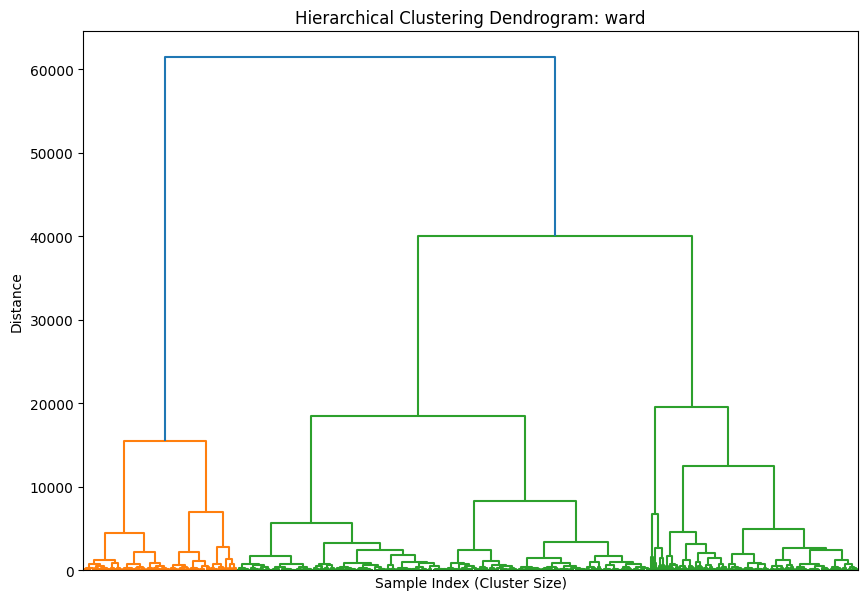

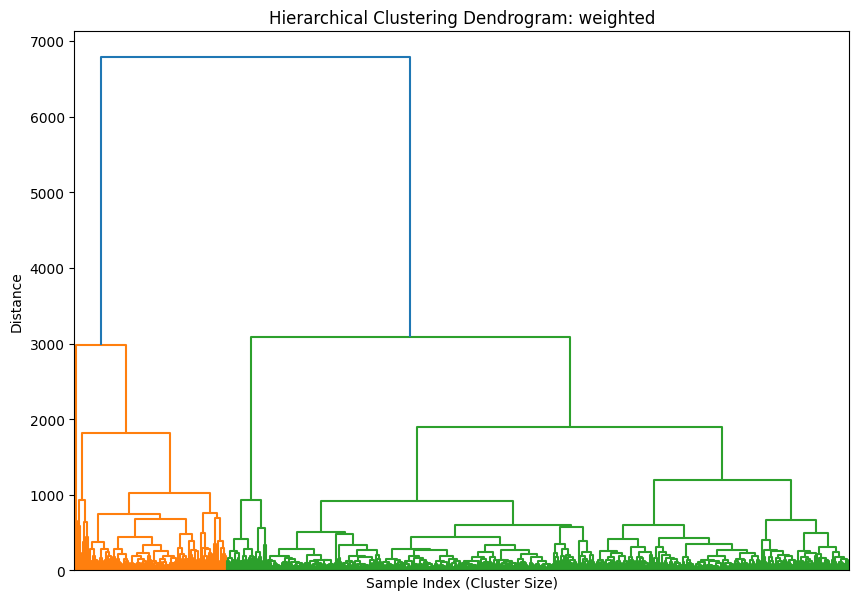

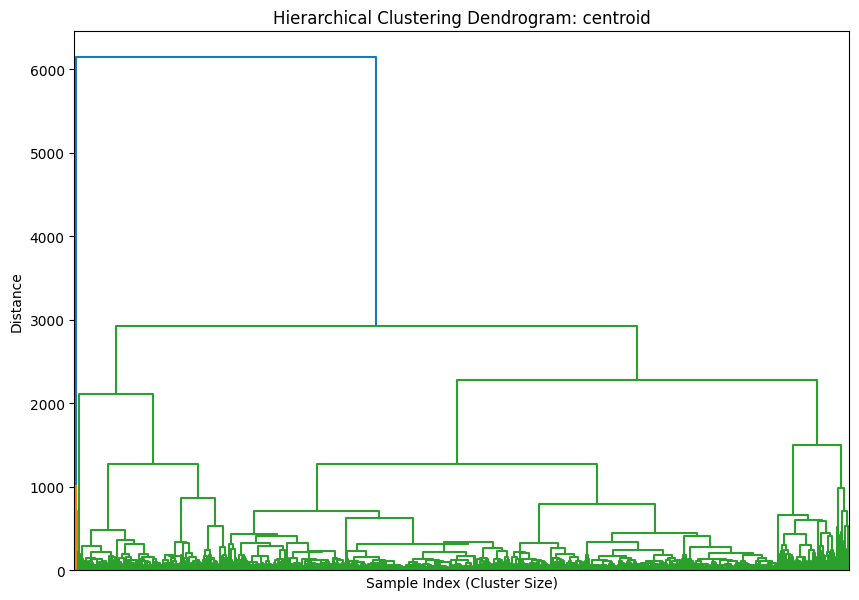

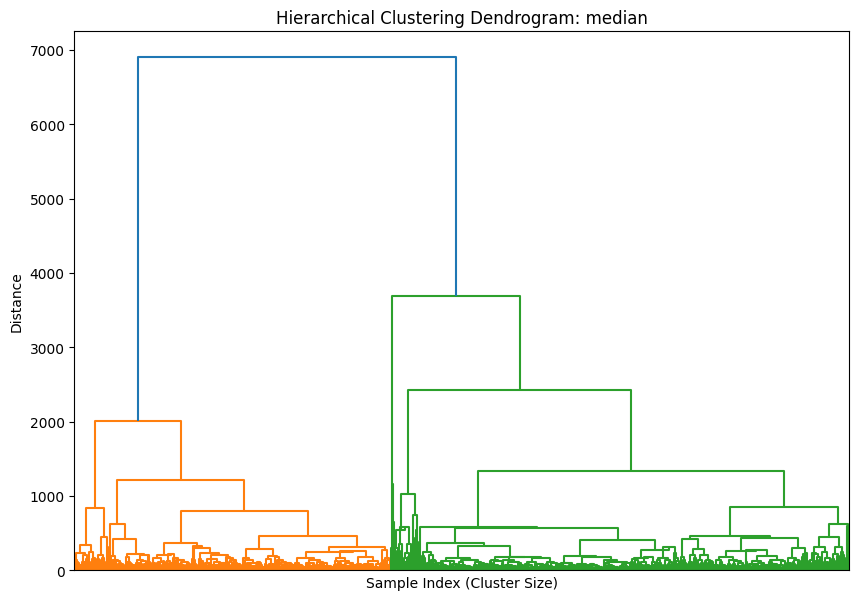

In [21]:
for i in ['single', 'complete', 'average', 'ward', 'weighted', 'centroid', 'median']:
    linkage_matrix = sch.linkage(features, method=i)
    plt.figure(figsize=(10, 7))
    sch.dendrogram(linkage_matrix, no_labels=True)
    plt.title(f'Hierarchical Clustering Dendrogram: {i}')
    plt.xlabel('Sample Index (Cluster Size)')
    plt.ylabel('Distance')
    plt.show()

### Test Methods

In [96]:
# Extract cluster assignments by cutting the dendrogram
# Cut the dendrogram at a specific distance to get 3 clusters
## MEDIAN 
linkage_matrix = sch.linkage(features, method='median')
distance_threshold = 5000  # Adjust this value as needed to separate clusters
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Create a DataFrame to analyze clusters
cluster_data = pd.DataFrame({'Filename': filenames, 'Cluster': cluster_labels})

# Investigate the orange and green clusters (assuming clusters are labeled 1, 2, 3)
orange_cluster = cluster_data[cluster_data['Cluster'] == 1]
green_cluster = cluster_data[cluster_data['Cluster'] == 2]


write_m3u(orange_cluster, 'orange_median.m3u')
write_m3u(green_cluster, 'green_median.m3u')

play_and_classify_m3u('orange_median.m3u', num_tracks=1)

play_and_classify_m3u('green_median.m3u', num_tracks=1)

Playing track 1 of 1: TRAINING_DATA/PREPARED/outro/015-20240926_me_oklahoma_prisoner_emmanuel_littlejohn_asks_for_clemency_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b



Classification Ratios:
M: 0.21
D: 0.33
B: 0.46
Music & Both: 67.3076923076923; Dialogue: 32.69230769230769
Playing track 1 of 1: TRAINING_DATA/PREPARED/outro/006-20241012_wesat_trump_has_made_a_colorado_town_central_to_his_narrative._residents_want_no_part_of_it_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b



Classification Ratios:
M: 0.00
D: 0.67
B: 0.33
Music & Both: 33.33333333333333; Dialogue: 66.66666666666666


{'M': 0, 'D': 14, 'B': 7}

In [ ]:
# Extract cluster assignments by cutting the dendrogram
# Cut the dendrogram at a specific distance to get 3 clusters
## WARD 
linkage_matrix = sch.linkage(features, method='ward')
distance_threshold = 20000  # Adjust this value as needed to separate clusters
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Create a DataFrame to analyze clusters
cluster_data = pd.DataFrame({'Filename': filenames, 'Cluster': cluster_labels})

# Investigate the orange and green clusters (assuming clusters are labeled 1, 2, 3)
orange_cluster = cluster_data[cluster_data['Cluster'] == 1]
green_cluster = cluster_data[cluster_data['Cluster'] == 2]


write_m3u(orange_cluster, 'orange_ward.m3u')
write_m3u(green_cluster, 'green_ward.m3u')

play_and_classify_m3u('orange_ward_.m3u', num_tracks=20)

play_and_classify_m3u('green_ward.m3u', num_tracks=20)

In [48]:
# Extract cluster assignments by cutting the dendrogram
# Cut the dendrogram at a specific distance to get 3 clusters
## WARD 
linkage_matrix = sch.linkage(features, method='complete')
distance_threshold = 10000  # Adjust this value as needed to separate clusters
cluster_labels = fcluster(linkage_matrix, distance_threshold, criterion='distance')

# Create a DataFrame to analyze clusters
cluster_data = pd.DataFrame({'Filename': filenames, 'Cluster': cluster_labels})

# Investigate the orange and green clusters (assuming clusters are labeled 1, 2, 3)
orange_cluster = cluster_data[cluster_data['Cluster'] == 1]
green_cluster = cluster_data[cluster_data['Cluster'] == 2]


write_m3u(orange_cluster, 'orange_complete.m3u')
write_m3u(green_cluster, 'green_complete.m3u')

play_and_classify_m3u('orange_complete.m3u', num_tracks=20)

play_and_classify_m3u('green_complete.m3u', num_tracks=20)

Playing track 1 of 20: TRAINING_DATA/PREPARED/outro/004-20241011_me_environmentalists_say_spacex_is_trashing_texas_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 2 of 20: TRAINING_DATA/PREPARED/outro/013-20241001_atc_pennsylvania_s_gov._shapiro_is_not_shocked_the_race_is_still_so_close_in_his_state_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 3 of 20: TRAINING_DATA/PREPARED/outro/019-20241010_atc_unsung_hero-jackie_briggs_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 4 of 20: TRAINING_DATA/PREPARED/outro/006-20241016_atc_prison_warden_reassigned_again_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 5 of 20: TRAINING_DATA/PREPARED/outro/015-20241008_me_mountain_hamlet_recovery_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 6 of 20: TRAINING_DATA/PREPARED/outro/008-20240930_me_helene_and_hot_ocean_water_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 7 of 20: TRAINING_DATA/PREPARED/outro/003-20241013_atc_prestigious_lasker_prize_awarded_to_south_african_scientists_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 8 of 20: TRAINING_DATA/PREPARED/outro/016-20241028_me_candidates_in_san_francisco_s_mayoral_race_voice_plans_on_fixing_homelessness_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 9 of 20: TRAINING_DATA/PREPARED/outro/018-20241004_me_as_helene_swept_through_western_north_carolina_it_flooded_a_critical_factory_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 10 of 20: TRAINING_DATA/PREPARED/outro/008-20241018_me_china_repeatedly_threatens_to_invade_taiwan._what_would_an_invasion_look_like_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 11 of 20: TRAINING_DATA/PREPARED/outro/003-20241014_atc_europa_clipper_launch_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 12 of 20: TRAINING_DATA/PREPARED/outro/014-20240927_atc_gps_back-up_atc_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 13 of 20: TRAINING_DATA/PREPARED/outro/006-20241014_me_library_as_entrepreneurial_hub_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 14 of 20: TRAINING_DATA/PREPARED/outro/005-20241024_atc_ca-22_running_towards_the_middle_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 15 of 20: TRAINING_DATA/PREPARED/outro/014-20241019_wesat_school_counselors_are_using_creative_ways_to_help_kids_cope_with_the_trauma_of_floods_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 16 of 20: TRAINING_DATA/PREPARED/outro/012-20241030_atc_white_house_tours_get_a_revamp_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 17 of 20: TRAINING_DATA/PREPARED/outro/013-20241007_atc_keeping_the_faith_and_staying_hopeful_through_the_darkness-one_rabbi_s_perspective_on_october_7th_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 18 of 20: TRAINING_DATA/PREPARED/outro/014-20241021_atc_summit_to_save_nature_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 19 of 20: TRAINING_DATA/PREPARED/outro/018-20241016_atc_mexican_restaurant_week_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 20 of 20: TRAINING_DATA/PREPARED/outro/003-20241005_wesat_opinion_political_texts_are_pinging_off_the_rails_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b



Classification Ratios:
M: 0.25
D: 0.05
B: 0.70
Music & Both: 95.0; Dialogue: 5.0
Playing track 1 of 20: TRAINING_DATA/PREPARED/outro/014-20241008_atc_longevity_analysis_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 2 of 20: TRAINING_DATA/PREPARED/outro/015-20241013_wesun_river_runners_are_celebrating_whitewater_rapids_re-emerging_in_colorado_s_lake_powell_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 3 of 20: TRAINING_DATA/PREPARED/outro/011-20241004_atc_with_fafsa_delayed_again_students_are_uncertain_about_how_to_stay_in_school_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 4 of 20: TRAINING_DATA/PREPARED/outro/016-20241025_atc_army_report_arlington_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 5 of 20: TRAINING_DATA/PREPARED/outro/007-20241023_me_hispanic_voters_speak_out_in_allentown_pa._a_majority_latino_city_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 6 of 20: TRAINING_DATA/PREPARED/outro/009-20241015_me_songs_that_move_you_ojal_que_llueva_caf_by_juan_luis_guerra_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 7 of 20: TRAINING_DATA/PREPARED/outro/013-20241012_wesat_extremism_experts_are_keeping_an_eye_on_an_event_targeted_at_women_in_washington_d.c._chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 8 of 20: TRAINING_DATA/PREPARED/outro/007-20241001_me_experts_deadly_flow_of_fentanyl_into_the_u.s._is_drying_up_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 9 of 20: TRAINING_DATA/PREPARED/outro/001-20241026_wesat_israel_conducts_retaliatory_airstrikes_against_iran_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 10 of 20: TRAINING_DATA/PREPARED/outro/016-20241020_wesun_researchers_are_skeptical_of_this_gunfire_detection_system._chicago_no_longer_uses_it_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 11 of 20: TRAINING_DATA/PREPARED/outro/014-20241023_atc_shareholder_nuns_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 12 of 20: TRAINING_DATA/PREPARED/outro/010-20241015_atc_az-latina_voters_on_abortion_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 13 of 20: TRAINING_DATA/PREPARED/outro/005-20241002_atc_remembering_john_amos_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 14 of 20: TRAINING_DATA/PREPARED/outro/003-20241017_me_u.k._mulls_sanctions_on_israeli_ministers_for_remarks_describe_as_abhorrent_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 15 of 20: TRAINING_DATA/PREPARED/outro/001-20241007_me_morning_news_brief_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 16 of 20: TRAINING_DATA/PREPARED/outro/004-20241027_atc_dua_lipa_talks_about_her_new_album_and_playing_a_venue_like_the_tiny_desk_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  b


Playing track 17 of 20: TRAINING_DATA/PREPARED/outro/018-20241026_wesat_a_new_graphic_novel_reimagines_huckleberry_finn_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 18 of 20: TRAINING_DATA/PREPARED/outro/002-20241005_wesat_week_in_politics_presidential_race_continues_to_be_tied_a_month_before_the_election_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d


Playing track 19 of 20: TRAINING_DATA/PREPARED/outro/016-20240926_atc_larry_hoover_hearing_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  m


Playing track 20 of 20: TRAINING_DATA/PREPARED/outro/004-20241009_atc_mixed-income_public_housing_chunk_1.mp3


Classify this track as M (Music), D (Dialogue), B (Both), or Q (Quit):  d



Classification Ratios:
M: 0.10
D: 0.50
B: 0.40
Music & Both: 50.0; Dialogue: 50.0


{'M': 2, 'D': 10, 'B': 8}

## Linkage Method Results

### Median

**Green Cluster**: 

- Music & Both: 33%
- Dialogue: 67%

**Orange Cluster**:

- Music & Both: 67%
- Dialogue: 32%

In [98]:
print(read_classifications('./green_median_classification.csv'))
print(read_classifications('./orange_median_classification.csv'))

({'M': 0, 'D': 14, 'B': 7}, {'Music & Both': 0.3333333333333333, 'Dialogue': 0.6666666666666666})
({'M': 11, 'D': 17, 'B': 24}, {'Music & Both': 0.6730769230769231, 'Dialogue': 0.3269230769230769})


### Complete

**Green Cluster**:

- Music & Both: 50%
- Dialogue: 50%

**Oragne Cluster**:

- Music & Both: 95%
- Dialogue: 5%

In [99]:
print(read_classifications('./green_complete_classification.csv'))
print(read_classifications('./orange_complete_classification.csv'))

({'M': 2, 'D': 10, 'B': 8}, {'Music & Both': 0.5, 'Dialogue': 0.5})
({'M': 5, 'D': 1, 'B': 14}, {'Music & Both': 0.95, 'Dialogue': 0.05})


### Ward

**Green Cluster**:

- Music & Both: 37%
- Dialogue: 63%

**Oragne Cluster**:

- Music & Both: 100%
- Dialogue: 0%

In [100]:
print(read_classifications('./green_ward_classification.csv'))
print(read_classifications('./orange_ward_classification.csv'))

({'M': 2, 'D': 19, 'B': 9}, {'Music & Both': 0.36666666666666664, 'Dialogue': 0.6333333333333333})
({'M': 9, 'D': 0, 'B': 21}, {'Music & Both': 1.0, 'Dialogue': 0.0})
